In [1]:
using DataFrames
using CSV
using Profile
using PProf
using Random
using JSON
using BSON

include("nn.jl")

n_patients       = 5366
DS_PATH_VAE      = "../dataset_artifacts_vae/"
STATE_SIZE       = 49
n_patients_train = 4866

5000

In [2]:
function load_dataset()
    ds = []
    for i = 1:n_patients
        p = JSON.parsefile(DS_PATH_VAE * "mdp_patient_" * string(i) * ".json")
        rewards, actions, states = p["rewards"], p["actions"], p["cont_trajectory"]
        d = Dict("s" => [], "a" => [], "r" => [], "sp" => [])
        for j = 1:length(actions)
            push!(d["s"], states[j])
            push!(d["a"], actions[j])
            push!(d["r"], rewards[j])
        end
        if d["r"][end] == 0
            d["r"][end] == 1.0
        end
        push!(ds, d)
        if i % 1000 == 1 || i == n_patients
            println("loaded patient $(i) of $(n_patients)")
        end
    end
    return ds
end

load_dataset (generic function with 1 method)

In [3]:
# load dataset
ds = load_dataset();

loaded patient 1 of 5366
loaded patient 1001 of 5366
loaded patient 2001 of 5366
loaded patient 3001 of 5366
loaded patient 4001 of 5366
loaded patient 5001 of 5366
loaded patient 5366 of 5366


In [4]:
# create neural network
nn = neural_network_model(n_input = STATE_SIZE * 2, n_output = 25,
    layer_config = [128, 64]);
init!(nn)

Chain(Dense(98, 128, relu), Dense(128, 64, relu), Dense(64, 25))

In [5]:
#
# create state feature vector, we concatenate past 4 states from
# trajectory to capture patient dynamics
#
function state_vector(S, i)
    function trs(i)
        i = max(1, i)
        return convert(Array{Float32}, S[i])
    end
    return vcat(trs(i - 1), trs(i))
    #return trs(i)
end

#
# return data for sarsa for next step of training
#
function make_sarsa_ij(ds, i, j)
    p  = ds[i]
    sz = size(p["a"])[1]
    s  = state_vector(p["s"], j)    
    a  = p["a"][j]
    r  = p["r"][j]
    done = false
    if j == sz
        sp, ap, done = nothing, nothing, true
    else
        sp = state_vector(p["s"], j + 1)    
        ap = p["a"][j + 1]
    end    
    return s, a, r, sp, ap, done
end

make_sarsa_ij (generic function with 1 method)

In [6]:
# s, a, r, sp, ap, done = make_sarsa_ij(ds, 1, 1)

In [7]:
# get input for a run to check if everything is ready training
# batch = make_batches([s], [[0.0 for i=1:25]], 1)

In [8]:
γ = 0.9999 # discount factor
# traint Q(s, a) with sarsa function 
batch_size = 512
batch_x    = []
batch_y    = []
curr_batch = 0
for iter = 1:100
    for i = 1:n_patients_train
        p = ds[i]
        for j in 1:(size(p["a"])[1])

            s, a, r, sp, ap, done = make_sarsa_ij(ds, i, j)
            target = predict(nn.model, [s])

            if done
                target[a] = r
            else
                spsa_value = predict(nn.model, [sp])[ap]
                target[a]  = r + γ * spsa_value
            end

            if curr_batch == batch_size
                batch = make_batches(batch_x, batch_y, batch_size)
                fit!(nn, batch, iters = 1, show_loss = false, η = 0.00001)
                curr_batch, batch_x, batch_y = 0, [], []
            else
                push!(batch_x, s)
                push!(batch_y, target)
                curr_batch += 1
            end
        end
        if i % 100 == 1
           print(".")
        end
    end
    println("iteration $(iter) completed")
end

......................................................iteration 1 completed
......................................................iteration 2 completed
......................................................iteration 3 completed
......................................................iteration 4 completed
......................................................iteration 5 completed
......................................................iteration 6 completed
......................................................iteration 7 completed
......................................................iteration 8 completed
......................................................iteration 9 completed
......................................................iteration 10 completed
......................................................iteration 11 completed
......................................................iteration 12 completed
......................................................iteration 13 completed
........

In [9]:
# save model 
model_path = "model_dsarsa_3.bson"
let model = cpu(nn.model)
    BSON.@save model_path model
    @info "Model saved: $(model_path)"
end

┌ Info: Model saved: model_dsarsa_3.bson
└ @ Main In[9]:5


In [10]:
# load model
BSON.@load model_path model
    
model = model |> gpu
nn2 = neural_network_model(n_input = STATE_SIZE * 2, n_output = 25,
                           layer_config = [128, 64]);
nn2.model = model

Chain(Dense(98, 128, relu), Dense(128, 64, relu), Dense(64, 25))

In [11]:
# compare and test that we correctly saved the model
p = 
s, a, r, sp, ap, done = make_sarsa_ij(ds, 5001, 2)

(Float32[0.4443687, 0.08728991, 0.29413852, -0.31209934, -0.15364528, -0.38182014, -0.40594727, -0.310497, 0.02372102, 0.060586818  …  -0.22280852, 0.061045144, 0.06235134, 0.06281411, -0.23485416, -0.23448868, -0.23405595, -0.5739797, -0.56734794, -0.56106305], 1, 0.0, Float32[0.4443687, 0.08728991, 0.29413852, -0.31209934, -0.15364528, -0.38182014, -0.40594727, -0.310497, 0.02372102, 0.060586818  …  -0.22280852, 0.061045144, 0.06235134, 0.06281411, -0.23485416, -0.23448868, -0.23405595, -0.5739797, -0.56734794, -0.56106305], 1, false)

In [12]:
predict(nn.model, [s]);

In [13]:
v = predict(nn2.model, [s]);

In [14]:
argmax(v)[1]

14

In [185]:
# compare single patient Clinician vs. AI-Clinician
function get_map(pid)
    p = JSON.parsefile(DS_PATH_VAE * "mdp_patient_" * string(pid) * ".json")
    return [round(v) for v in p["MAP"]]
end

for i in [5044, 5025, 5200, 5300]
    cli = []
    ai  = []
    for j in 1:(size(ds[i]["a"])[1])
        s, a, _ = make_sarsa_ij(ds, i, j)
        h = predict(nn.model, [s])
        h_a = argmax(vec(h))
        push!(cli, a)
        push!(ai, h_a)
    end
    println("cli$(i)=",cli)
    println("ai$(i)=",ai)
    println("map$(i)=",get_map(i))
    println()
    println()
end

cli5044=Any[7, 7, 7, 12, 17, 22, 22, 22, 17, 16, 16, 23, 23, 22, 22, 12, 6, 2, 2, 1, 2, 1]
ai5044=Any[25, 17, 25, 25, 16, 9, 9, 9, 9, 9, 10, 9, 13, 9, 9, 10, 15, 20, 20, 9, 20, 6]
map5044=Real[68, 60, 62.0, 67, 63.0, 57, 62.0, 60, 63.0, 66, 70, 62.0, 61, 53, 61, 70.0, 49, 53, 51, 51, 32.0, 75]


cli5025=Any[12, 15, 20, 20, 15, 15, 15, 15, 14, 13, 13, 13, 13, 15, 15, 13, 13, 18, 23, 23, 23, 23, 23, 23, 23, 25, 25, 24, 23, 23, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 25, 24, 23, 23, 25, 25, 23, 23, 23, 23, 23, 23, 23, 25, 1]
ai5025=Any[9, 9, 9, 9, 9, 9, 9, 10, 10, 18, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 19, 9, 9, 9, 7, 10, 7, 9, 9, 9, 9, 9, 6]
map5025=Real[89.0, 108.0, 75, 65, 99, 92, 101, 108, 96.0, 85.0, 73, 74, 80, 76, 73, 73, 67, 65, 67, 70, 66, 74, 73, 73, 74.0, 79, 84, 74, 83, 78, 77, 80, 73, 69, 75, 77, 85, 86, 90, 86, 79.0, 72, 76, 79, 69, 61.0, 74, 65, 70, 55.0, 80.0, 72.0, 74, 67, 60,

In [176]:
function get_map(pid)
    p = JSON.parsefile(DS_PATH_VAE * "mdp_patient_" * string(pid) * ".json")
    return [round(v) for v in p["MAP"]]
end

get_map (generic function with 1 method)

In [184]:
JSON.parsefile(DS_PATH_VAE * "mdp_patient_5025.json")["rewards"]

60-element Array{Any,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -1.0
 -1.0

In [57]:
# to get Pressor Dose from action
a2pressor = [(0, 0.04), (0.04, 0.10), (0.10, 0.15), (0.15, 0.20), (0.20, Float64(Inf))]
# to get Fluid Dose from action
a2fluid   = [(0, 16.0), (16.0, 43.23), (43.23, 88.71), (88.71, 223.96), (223.96, Float64(Inf))]

function act2meds(a)
    pressor = div(a + 4, 5)
    fluid   = (a - 1) % 5 + 1
    return pressor, fluid
end

act2meds (generic function with 1 method)

In [25]:
# return side-by-side clinician vs. ai-clinician actions for passed patient range
function get_policy_actions(patient_range)
    global nn, ds
    result = []
    
    for i = patient_range
        p       = ds[i]
        actions = []
        r       = 0
        for j in 1:(size(p["a"])[1])
            s, a_cli, r, _ = make_sarsa_ij(ds, i, j)
            a_ai = argmax(vec(predict(nn.model, [s])))
            push!(actions, (a_cli, a_ai))
        end
        pdied = r < 0
        push!(result, [actions, pdied])
        
    end
    return result
end

get_policy_actions (generic function with 1 method)

In [58]:
# returns distribution of pressor for actions array (returned by get_policy_actions), id (1 for clinician 2 for AI clinitian), mortality
function get_pressor_distribution(actions, mortality)
    clinician    = [[0.0 for i=1:5], [0.0 for i=1:5]] # pressor and fluid distribution
    ai_clinician = [[0.0 for i=1:5], [0.0 for i=1:5]]
    
    for t in actions
        if t[2] != mortality
            continue
        end
        for as in t[1]
            cli, ai = as[1], as[2]
            cli_pressor, cli_fluid = act2meds(cli)
            ai_pressor, ai_fluid = act2meds(ai)
            clinician[1][cli_pressor] += 1
            clinician[2][cli_fluid] += 1
            ai_clinician[1][ai_pressor] += 1
            ai_clinician[2][ai_fluid] += 1
        end
    end
    clinician, ai_clinician
end
    

get_pressor_distribution (generic function with 2 methods)

In [33]:
vals = get_policy_actions(4866:5366);

In [60]:
distr_deceased = get_pressor_distribution(vals, true)
distr_survived = get_pressor_distribution(vals, false)

([[11553.0, 3346.0, 1520.0, 700.0, 2787.0], [6841.0, 6620.0, 1350.0, 1404.0, 3691.0]], [[2319.0, 2720.0, 5547.0, 6136.0, 3184.0], [4709.0, 1595.0, 4085.0, 5473.0, 4044.0]])

In [75]:
using StatsPlots;
using Plots;

In [188]:
distr_deceased

([[6387.0, 1806.0, 1131.0, 541.0, 3398.0], [4110.0, 4753.0, 1328.0, 905.0, 2167.0]], [[664.0, 2767.0, 4607.0, 2795.0, 2430.0], [1557.0, 923.0, 2666.0, 4647.0, 3470.0]])

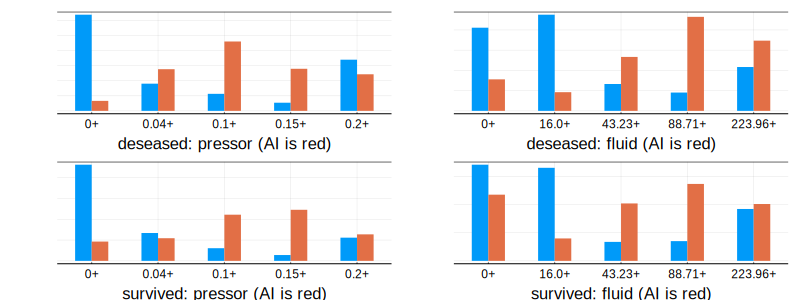

In [156]:
using Distributions

function category_groupbar(data, ctg, nam; xlabel = "", ylabel = "", title = "", subplot = 1)

    StatsPlots.groupedbar!(nam, data, xlabel = xlabel, labels = false,
        ylabel = ylabel, title =title, bar_width = 0.5, lw = 0, framestyle = :box, subplot = subplot, legendtitlefontsize = 4, yaxis = false)
    
end

dcli = distr_deceased[1]
dai  = distr_deceased[2]
scli = distr_survived[1]
sai  = distr_survived[2]

ctg = repeat(["Ph", "AI"], inner = 5)
nam_pressor = repeat(["$(v[1])+" for v in a2pressor], outer = 2)
nam_fluid = repeat(["$(v[1])+" for v in a2fluid], outer = 2)

plot(layout=(2,2), size = (800, 300))

category_groupbar([dcli[1] dai[1]], ctg, nam_pressor, xlabel = "deseased: pressor (AI is red)", subplot = 1)
category_groupbar([dcli[2] dai[2]], ctg, nam_fluid, xlabel = "deseased: fluid (AI is red)", subplot = 2)

category_groupbar([scli[1] sai[1]], ctg, nam_pressor, xlabel = "survived: pressor (AI is red)", subplot = 3)
category_groupbar([scli[2] sai[2]], ctg, nam_fluid, xlabel = "survived: fluid (AI is red)", subplot = 4)